In [ ]:

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam


In [ ]:
#install kaggle to download dataset
! pip install -q kaggle

from google.colab import files

#upload kaggle API
files.upload()

In [ ]:
#make directory kaggle json
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
# Downloaded dataset will be in temp session storage
# You can check it by clicking the folder icon on the left
!kaggle datasets download -d landlord/handwriting-recognition

handwriting-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#extract zip and move it to designed directory
!mkdir Dataset
with zipfile.ZipFile("/content/handwriting-recognition.zip", "r") as zip_ref:
    zip_ref.extractall("/content/Dataset")

# Delete the zip file
# os.remove("/content/handwriting-recognition.zip")

In [ ]:
# Read the csv files
train = pd.read_csv('/content/Dataset/written_name_train_v2.csv')
valid = pd.read_csv('/content/Dataset/written_name_validation_v2.csv')

In [ ]:
# preview sample data from train dataset
# preview 8 images on random

import random

plt.figure(figsize=(15, 10))

# Get a list of 8 random indices from the dataset
random_indices = random.sample(range(len(train)), 8)

for i, idx in enumerate(random_indices):
    ax = plt.subplot(2, 4, i+1)
    img_dir = '/content/Dataset/train_v2/train/' + train.loc[idx, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    plt.title(train.loc[idx, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

In [ ]:
# Check total images in train and validation dataset

print("Training images:", len(train))
print("Validation images:", len(valid))

Training images: 330961
Validation images: 41370


In [ ]:
# Cleaning process

# Dataset has some missing values
# We will remove those rows with missing values


# Check for missing values
train_missing_values = train.isnull().sum()
valid_missing_values = valid.isnull().sum()

# Remove rows with missing values
train.dropna(inplace=True)
valid.dropna(inplace=True)

# Preview sample data after removal of missing values
train_missing_values_after_removal = train.isnull().sum()
valid_missing_values_after_removal = valid.isnull().sum()

# Print the number of missing values before and after removal
print("Train Missing values before removal:\n", train_missing_values)
print("Valid Missing values before removal:\n", valid_missing_values)
print("\nTrain Missing values after removal:\n", train_missing_values_after_removal)
print("\nValid Missing values after removal:\n", valid_missing_values_after_removal)





Train Missing values before removal:
 FILENAME      0
IDENTITY    565
dtype: int64
Valid Missing values before removal:
 FILENAME     0
IDENTITY    78
dtype: int64

Train Missing values after removal:
 FILENAME    0
IDENTITY    0
dtype: int64

Valid Missing values after removal:
 FILENAME    0
IDENTITY    0
dtype: int64


In [ ]:
# More cleaning process

# Dataset has some unreadable images
# We will remove those rows with unreadable images
# (Identity column has value 'UNREADABLE')

# Check for unreadable images
# Don't include the rows with unreadable images
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [ ]:
# Some names are in lowercase and some are in uppercase
# Convert names to uppercase for consistent naming

train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [ ]:
# Reset the index of the dataframes
# After removing some rows, the indices are not in order    

train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [ ]:
#pre process data (resizing & rotating)
def preprocess(image, width=256, height=64):
  # Resize the image to the desired width and height.
  resized_image = cv2.resize(image, (width, height))

  # If the image is smaller than the desired size, pad it with white pixels.
  if resized_image.shape[0] < width or resized_image.shape[1] < height:
    pad_top = max(0, width - resized_image.shape[0])
    pad_bottom = max(0, height - resized_image.shape[1])
    pad_left = max(0, width - resized_image.shape[0])
    pad_right = max(0, height - resized_image.shape[1])
    pad_color = (255, 255, 255)
    padded_image = cv2.copyMakeBorder(resized_image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=pad_color)
  else:
    padded_image = resized_image

  # Rotate the image clockwise.
  rotated_image = cv2.rotate(padded_image, cv2.ROTATE_90_CLOCKWISE)

  return rotated_image


In [ ]:
# Preview number of data after cleaning process

print("Pre-processed Training images:", len(train))
print("Pre-processed Validation images:", len(valid))

Pre-processed Training images: 330294
Pre-processed Validation images: 41280


In [ ]:
# Set the amount of training and validation data
# Total training images = 330961
# Total validation images = 41370

# We only use 30000 images for training and 3000 images for validation because of limited resources
# You can change this number to a higher number if you want to train on more data for better accuracy
train_images = 30000
valid_images= 3000



In [ ]:
# Create loop to pre-process images and store them in an array

train_x = []

for i in range(train_images):
    #read file
    img_dir = '/content/Dataset/train_v2/train/'+train.loc[i, 'FILENAME']
    #convert to greyscale
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    #pre-process with function preprocess we create before
    image = preprocess(image)
    #Normalizing the pixel values to the range of 0-1 
    image = image/255.
    #Append image to train_x
    train_x.append(image)



In [ ]:
# Do the same for validation data
valid_x = []

for i in range(valid_images):
    img_dir = '/content/Dataset/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
# #acak urutan data untuk hindari potensi bias atau pattern dari original data
# random.shuffle(train_x)
# random.shuffle(valid_x)

In [ ]:
# Reshape the images

train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [ ]:
# Create a list of all the characters that can occur in the names
# We will use this to create the character dictionary

alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels
batch_size = 128

# Create a dictionary mapping characters to integers
def label_to_num(label):
    label_num = []
    for ch in label:
        
            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))
        
    return np.array(label_num)

# Create a dictionary mapping integers back to characters
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
# Convert the names to numbers for training and validation data

train_y = np.ones([train_images, max_str_len]) * -1
train_label_len = np.zeros([train_images, 1])
train_input_len = np.ones([train_images, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_images])

for i in range(train_images):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [ ]:
valid_y = np.ones([valid_images, max_str_len]) * -1
valid_label_len = np.zeros([valid_images, 1])
valid_input_len = np.ones([valid_images, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_images])

for i in range(valid_images):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [ ]:
# Define input shape
input_image = Input(shape=(256, 64, 1), name='input')

# Convolutional layers
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_image)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN transition
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# Bi-RNN layers
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# Output layer
num_of_characters = num_of_characters = len(ALPHABETS) + 1
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

# Create the model
model = Model(inputs=input_image, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [ ]:

# CTC loss function
def ctc_lambda_func(args):
    """
    Compute the CTC (Connectionist Temporal Classification) loss function.
    
    Args:
        args (tuple): Tuple containing y_pred, labels, input_length, and label_length.
            y_pred (tensor): Predicted output from the model.
            labels (tensor): True labels for the input samples.
            input_length (tensor): Length of input sequence.
            label_length (tensor): Length of true labels.
    
    Returns:
        tensor: CTC loss value.
    """
    y_pred, labels, input_length, label_length = args
    
    # Exclude the first two elements from y_pred (CTC pseudo blank)
    y_pred = y_pred[:, 2:, :]
    
    # Compute CTC batch cost
    ctc_loss = K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    
    return ctc_loss


In [ ]:
# Define inputs for the model
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Compute CTC loss using the custom lambda function
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# Create the final model with inputs and outputs
model_final = Model(inputs=[input_image, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
# Use a dummy lambda function for the loss calculation
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0001))

# Fit the model to the training data
history = model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
    epochs=60,
    batch_size=128
)

Epoch 1/60
235/235 [==============================] - 268s 1s/step - loss: 19.7934 - val_loss: 20.3290
Epoch 2/60
235/235 [==============================] - 261s 1s/step - loss: 18.7386 - val_loss: 18.1215
Epoch 3/60
235/235 [==============================] - 261s 1s/step - loss: 17.3354 - val_loss: 16.7903
Epoch 4/60
235/235 [==============================] - 261s 1s/step - loss: 15.5236 - val_loss: 15.5768
Epoch 5/60
235/235 [==============================] - 260s 1s/step - loss: 13.4368 - val_loss: 14.0825
Epoch 6/60
235/235 [==============================] - 261s 1s/step - loss: 11.0028 - val_loss: 10.0897
Epoch 7/60
235/235 [==============================] - 261s 1s/step - loss: 8.8764 - val_loss: 8.0957
Epoch 8/60
235/235 [==============================] - 260s 1s/step - loss: 7.4607 - val_loss: 6.7735
Epoch 9/60
235/235 [==============================] - 261s 1s/step - loss: 6.5411 - val_loss: 6.4514
Epoch 10/60
235/235 [==============================] - 261s 1s/step - loss: 5.8

In [ ]:
def processImage(img):
    canvas_height, canvas_width = 64, 256
    canvas = np.ones((canvas_height, canvas_width), dtype=np.uint8) * 255  # Create blank white canvas
    
    img_height, img_width = img.shape[:2]
    img_aspect_ratio = img_width / img_height
    
    if img_aspect_ratio > canvas_width / canvas_height:
        # Image is wider, so limit the width to fit within the canvas
        resized_width = int(canvas_width * 0.8)  # Adjust the scale factor as desired
        resized_height = int(resized_width / img_aspect_ratio)
    else:
        # Image is taller or has the same aspect ratio, so limit the height to fit within the canvas
        resized_height = int(canvas_height * 0.8)  # Adjust the scale factor as desired
        resized_width = int(resized_height * img_aspect_ratio)
    
    resized_img = cv2.resize(img, (resized_width, resized_height))
    
    x = (canvas_width - resized_width) // 2  # Calculate x-coordinate for centering the image
    y = (canvas_height - resized_height) // 2  # Calculate y-coordinate for centering the image
    
    x_end = x + resized_width
    y_end = y + resized_height
    
    canvas[y:y_end, x:x_end] = resized_img
    
    return canvas

1/1 [==============================] - 0s 42ms/step


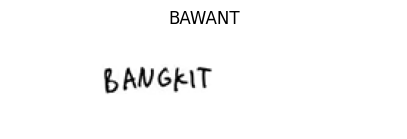

In [ ]:
plt.figure(figsize=(5, 5))  # Adjust the figure size accordingly

ax = plt.subplot(1, 1, 1)  # Use a single subplot
img_dir = 'rezos.png'  # Path to your own image file

image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image / 255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1],
                                   greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

plt.show()

1/1 [==============================] - 0s 40ms/step


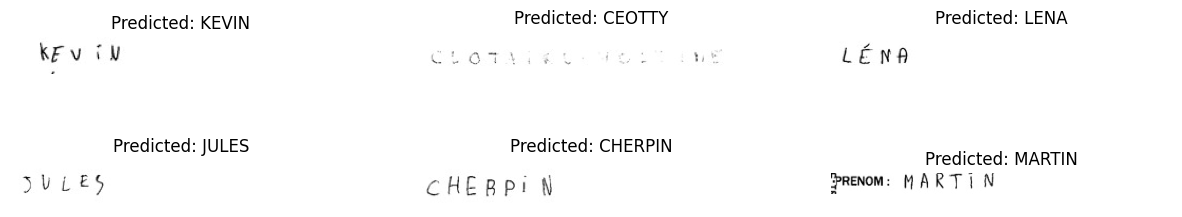

In [ ]:
test = pd.read_csv('/content/Dataset/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/Dataset/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title("Predicted: " + num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

1/1 [==============================] - 0s 42ms/step


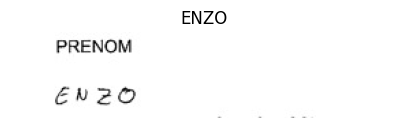

In [ ]:
test = pd.read_csv('/content/Dataset/written_name_test_v2.csv')

plt.figure(figsize=(5, 5))  # Adjust the figure size accordingly
i = 142  # Select the index of the image you want to feed

ax = plt.subplot(1, 1, 1)  # Use a single subplot
img_dir = '/content/Dataset/test_v2/test/' + test.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image / 255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1],
                                   greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
# Save the model
# Change the name and path accordingly
model.save('model.h5')

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = model_final.history['accuracy']
val_acc = model_final.history['val_accuracy']
loss = model_final.history['loss']
val_loss = model_final.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()